# Transfer Learning and Fine-Tuning on VOC2007  
We studt here the « transfer learning» capacities of deep ConvNets trained on large-scale datasets such as ImageNet.  
We will work with the PASCAL VOC2007 dataset <http://host.robots.ox.ac.uk/pascal/VOC/voc2007/>, which contains:  
- 20 classes (macro-categories Person, Animal, Vehicle, Indoor), with « multi-labels » annotations.  
- The training set (train+val) contains about 5000 images, the test set also contains about 5000 images.  

With such dataset size, it is not possible to train large ConvNet such as those used on ImageNet without highly suffering from overfitting. We study here transfer learning to overcome the problem.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import  torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
from torchvision.datasets import VOCDetection
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

# 0) PASCAL VOC dataset and data loaders

In [2]:
# ImageNet RGB mean and std [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
meanR=0.485
meanG=0.456
meanB=0.406

stdR=0.229
stdG=0.224
stdB=0.225

# Image classes on PASCAL VOC
object_categories = ['tvmonitor', 'aeroplane', 'boat', 'dog', 'train', 'cat', 'sofa', 'bird', 'bus', 'pottedplant', 'person', 'diningtable', 'bottle', 'car', 'horse', 'bicycle', 'sheep', 'cow', 'chair', 'motorbike']



In [3]:
# Data transforms (normalization)
stats = ((meanR, meanG, meanB), (stdR, stdG, stdB))

train_tfms=tt.Compose([
    tt.Resize((224, 224)),
    tt.ToTensor(), 
    tt.Normalize(*stats,inplace=True)
                      ])
test_tfms = tt.Compose([
    tt.Resize((224, 224)),
    tt.ToTensor(),
     tt.Normalize(*stats,inplace=True)                                
                      ])

In [4]:
def encode_labels(target):
    """
    Encode multiple labels using 1/0 encoding 
    Args:
        target: xml tree file
    Returns:
        torch tensor encoding labels as 1/0 vector
    """

    ls = target['annotation']['object']
    j = []

    if type(ls) == dict:
        if int(ls['difficult']) == 0:
            j.append(object_categories.index(ls['name']))
    else:
        for i in range(len(ls)):
            if int(ls[i]['difficult']) == 0:
                j.append(object_categories.index(ls[i]['name']))
    k = np.zeros(len(object_categories))
    k[j] = 1
    return torch.from_numpy(k)


def get_label_txt(label):
    """
    Get Label text from numpy array encoded as 1/o vector
    Args:
        label: xml tree file
    Returns:
        List of  categories string
    """

    k = label.numpy()
    labeltext=[]
    for i in range(len(k)):
      if k[i] >= 1:      
        labeltext.append(object_categories[i])

    return labeltext

## Get train and test datastests

In [5]:
train_dataset = VOCDetection(root='data/',year ='2007',image_set='trainval', download=True, transform=train_tfms,target_transform=encode_labels)
test_dataset = VOCDetection(root='data/', year = '2007',image_set='test', download=True, transform=test_tfms,target_transform=encode_labels)

train_dataset_size = len(train_dataset)
test_dataset_size = len(test_dataset)
train_dataset_size,test_dataset_size


  0%|          | 0/460032000 [00:00<?, ?it/s]

Extracting data/VOCtrainval_06-Nov-2007.tar to data/


  0%|          | 0/451020800 [00:00<?, ?it/s]

Extracting data/VOCtest_06-Nov-2007.tar to data/


(5011, 4952)

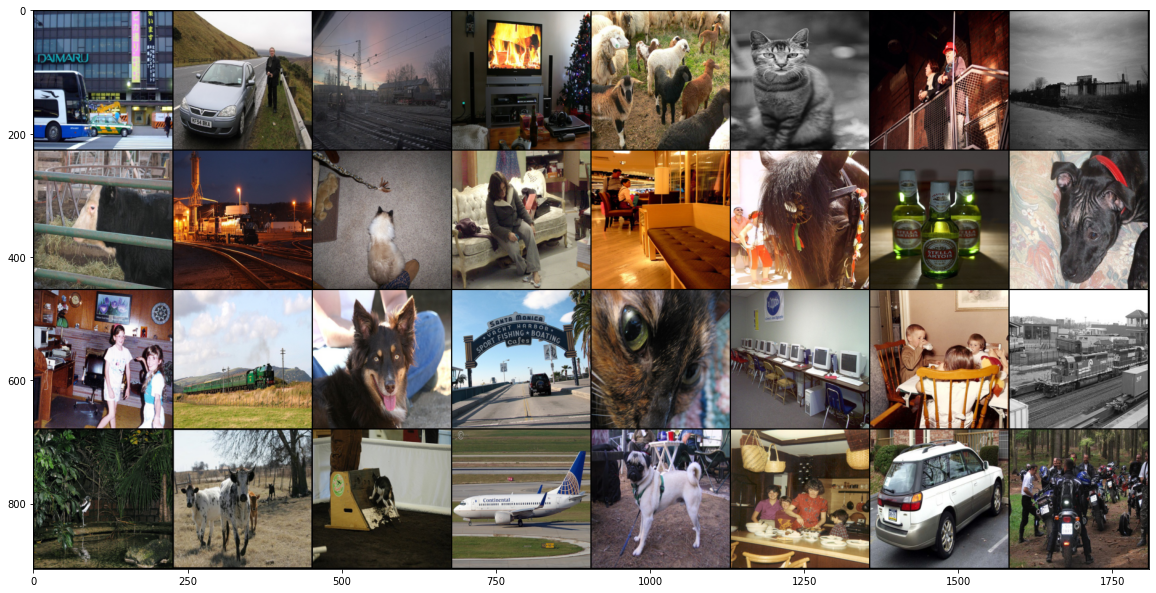

In [6]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means
def show_batch(dl):
    fig, ax = plt.subplots(figsize=(20,20))#(nrows=4, ncols=4,figsize=(6, 6))
    images, labels = next(iter(dl))
    denorm_images = denormalize(images, *stats)
    ax.imshow(make_grid(denorm_images[:32], nrow=8).permute(1, 2, 0).clamp(0,1))

batch_size = 32
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=1, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size, num_workers=1, pin_memory=True)

show_batch(train_dl)        

# I) Transfer Learning 

### First, lets download a pre-trained ResNet-50 model

In [7]:
from torchvision import models
model = models.resnet50(pretrained=True).to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## I.A) Deep Feature extraction

We will extract deep feature after the average pool layer 

In [8]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.avgpool.register_forward_hook(get_activation('avgpool'))

**Look at the shape of the deep features extracted from a batch:**

In [9]:
images, labels = next(iter(train_dl))
output = model(images.to(device))
DF = activation['avgpool'].view(batch_size, 2048).cpu().numpy()
print(DF.shape)

(32, 2048)


**Now lets extract deep features on the whole dataset! And store them.**

In [10]:
train_dataset_size = len(train_dataset)

X_train = torch.zeros((train_dataset_size,2048))
Y_train = torch.zeros((train_dataset_size,20))

# Calcul du nombre de batchs  
nb_batches = int(train_dataset_size / batch_size) + 1  

print(f"nb batches={nb_batches}")

for i, (images, labels) in enumerate(train_dl):
  #print(images.shape)
  #print(labels.shape)
  with torch.no_grad():
    output = model(images.to(device))
  # YOUR CODE HERE
  X_train[i*batch_size:(i+1)*batch_size,:] = activation['avgpool'].view(images.shape[0], 2048).cpu()#.numpy()
  Y_train[i*batch_size:(i+1)*batch_size,:] = labels

  if(i%10==0 or i==(nb_batches-1)):
    print(f" Batch {i+1} - nb ex={images.shape[0]}")


nb batches=157
 Batch 1 - nb ex=32
 Batch 11 - nb ex=32
 Batch 21 - nb ex=32
 Batch 31 - nb ex=32
 Batch 41 - nb ex=32
 Batch 51 - nb ex=32
 Batch 61 - nb ex=32
 Batch 71 - nb ex=32
 Batch 81 - nb ex=32
 Batch 91 - nb ex=32
 Batch 101 - nb ex=32
 Batch 111 - nb ex=32
 Batch 121 - nb ex=32
 Batch 131 - nb ex=32
 Batch 141 - nb ex=32
 Batch 151 - nb ex=32
 Batch 157 - nb ex=19


In [15]:
test_dataset_size = len(test_dataset)

X_test= torch.zeros((test_dataset_size,2048))
Y_test = torch.zeros((test_dataset_size,20))
# Calcul du nombre de batchs  
nb_batches = int(test_dataset_size / batch_size) + 1  

print(f"nb batches={nb_batches}")

for i, (images, labels) in enumerate(test_dl):
  #print(images.shape)
  #print(labels.shape)
  with torch.no_grad():
    output = model(images.to(device))
  X_test[i*batch_size:(i+1)*batch_size,:] = activation['avgpool'].view(images.shape[0], 2048).cpu()#.numpy()
  Y_test[i*batch_size:(i+1)*batch_size,:] = labels

  if(i%10==0 or i==(nb_batches-1)):
    print(f" Batch {i+1} - nb ex={images.shape[0]}")

nb batches=155
 Batch 1 - nb ex=32
 Batch 11 - nb ex=32
 Batch 21 - nb ex=32
 Batch 31 - nb ex=32
 Batch 41 - nb ex=32
 Batch 51 - nb ex=32
 Batch 61 - nb ex=32
 Batch 71 - nb ex=32
 Batch 81 - nb ex=32
 Batch 91 - nb ex=32
 Batch 101 - nb ex=32
 Batch 111 - nb ex=32
 Batch 121 - nb ex=32
 Batch 131 - nb ex=32
 Batch 141 - nb ex=32
 Batch 151 - nb ex=32
 Batch 155 - nb ex=24


## I.B) Linear model on top of deep features


In [16]:
class LR(nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.fc1 = nn.Linear(2048, 20)

    def forward(self, x):
        return self.fc1(x)

In [17]:
lr = LR().to(device)
print(lr)
#X_train = torch.from_numpy(X_train).to(device)
#X_train = X_train.to(torch.float32)
print(X_train.dtype)
print(lr.fc1.weight.dtype)

pred = lr(X_train.to(device))
print(pred.shape)

LR(
  (fc1): Linear(in_features=2048, out_features=20, bias=True)
)
torch.float32
torch.float32
torch.Size([5011, 20])


**We have a multi-label classification problems: performances will be evaluated as the Average Precision (AP) over all  (20) class**

In [18]:
from sklearn.metrics import average_precision_score

def AP_score(predictions, targets):
  APs = np.zeros(20)  

  for c in range(20):  
    APs[c] = average_precision_score(targets[:, c], predictions[:, c])  

  return APs  

## Fill the training loop:
- Which loss to use? Why not using the standard multi-class cross entropy loss?  

In [19]:
nepochs = 20

optimizer = torch.optim.SGD(lr.parameters(), lr=0.5)
criterion = F.binary_cross_entropy_with_logits

nb_batches = int(train_dataset_size / batch_size) + 1  

for e in range(nepochs): 
  # Faire un randperm des indices
  for i in range(nb_batches): 
    optimizer.zero_grad()   
    pred = lr(X_train[i*batch_size:i*batch_size+batch_size].to(device))
    loss = criterion(pred, Y_train[i*batch_size:i*batch_size+batch_size].to(device))
    loss.backward()
    optimizer.step()

  
  #print(AP_train)
  #AP_train = AP_score(pred.detach().cpu().numpy(),Y_train.detach().cpu().numpy())%100.0
  if( e%1==0 or e==(nepochs-1)):
    pred_train = lr(X_train.to(device))
    AP_train = AP_score(pred_train.detach().cpu(),Y_train.detach().cpu())*100.0
    pred_test = lr(X_test.to(device))
    AP_test = AP_score(pred_test.detach().cpu(),Y_test.detach().cpu())*100.0
    print(f" epoch {e+1:d} - AP Train = {AP_train.mean():.2f} - AP Test = {AP_test.mean():.2f}")

 epoch 1 - AP Train = 79.90 - AP Test = 79.19
 epoch 2 - AP Train = 83.23 - AP Test = 81.51
 epoch 3 - AP Train = 84.93 - AP Test = 82.48
 epoch 4 - AP Train = 86.05 - AP Test = 82.98
 epoch 5 - AP Train = 86.91 - AP Test = 83.27
 epoch 6 - AP Train = 87.58 - AP Test = 83.45
 epoch 7 - AP Train = 88.17 - AP Test = 83.57
 epoch 8 - AP Train = 88.66 - AP Test = 83.64
 epoch 9 - AP Train = 89.10 - AP Test = 83.68
 epoch 10 - AP Train = 89.49 - AP Test = 83.70
 epoch 11 - AP Train = 89.86 - AP Test = 83.71
 epoch 12 - AP Train = 90.19 - AP Test = 83.70
 epoch 13 - AP Train = 90.49 - AP Test = 83.68
 epoch 14 - AP Train = 90.77 - AP Test = 83.67
 epoch 15 - AP Train = 91.02 - AP Test = 83.65
 epoch 16 - AP Train = 91.26 - AP Test = 83.62
 epoch 17 - AP Train = 91.48 - AP Test = 83.59
 epoch 18 - AP Train = 91.69 - AP Test = 83.57
 epoch 19 - AP Train = 91.88 - AP Test = 83.53
 epoch 20 - AP Train = 92.07 - AP Test = 83.51


# II) Fine-tuning

**To fine-tune the model, we simply change (and re-initialize) the last fully connected layer:**

In [20]:
model = models.resnet50(pretrained=True).to(device)
#print(model)
# Changing the fully connected layers
model.fc = nn.Linear(2048, 20)
model = model.to(device)
#print(model)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
nepochs = 20

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
criterion = F.binary_cross_entropy_with_logits

#nb_batches = int(train_dataset_size / batch_size) + 1 
pred_all_train = torch.zeros((train_dataset_size,20))
labels_all_train = torch.zeros((train_dataset_size,20))

pred_all_test = torch.zeros((test_dataset_size,20))
labels_all_test = torch.zeros((test_dataset_size,20))

for e in range(nepochs): 
  total_loss = 0.0
  for i, (images, labels) in enumerate(train_dl):
    optimizer.zero_grad()
    pred = model(images.to(device))
    loss = criterion(pred, labels.to(device))
    total_loss += loss
    loss.backward()
    optimizer.step()

  print(f" epoch {e+1:d} - loss = {total_loss:.2f}")

  for i, (images, labels) in enumerate(train_dl):
    with torch.no_grad():
      output = model(images.to(device))
    pred_all_train[i*batch_size:(i*batch_size+output.shape[0]),:] = output
    labels_all_train[i*batch_size:(i*batch_size+output.shape[0]),:]= labels
  
  for i, (images, labels) in enumerate(test_dl):
    with torch.no_grad():
      output = model(images.to(device))
    pred_all_test[i*batch_size:(i*batch_size+output.shape[0]),:] = output
    labels_all_test[i*batch_size:(i*batch_size+output.shape[0]),:] = labels

  AP_train = AP_score(pred_all_train.detach().cpu(),labels_all_train.detach().cpu())*100.0
  AP_test = AP_score(pred_all_test.detach().cpu(),labels_all_test.detach().cpu())*100.0
  print(f" epoch {e+1:d} - AP Train = {AP_train.mean():.2f} - AP Test = {AP_test.mean():.2f}")


 epoch 1 - loss = 25.44
 epoch 1 - AP Train = 76.54 - AP Test = 74.61
 epoch 2 - loss = 14.38


# Trash from here

In [ ]:
test_dataset_size = len(test_dataset)

In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!tar -xvf VOCtrainval_06-Nov-2007.tar
!rm VOCtrainval_06-Nov-2007.tar

In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!tar -xvf VOCtrainval_06-Nov-2007.tar
!rm VOCtrainval_06-Nov-2007.tar

In [ ]:
!cd VOCdevkit

In [ ]:
%cd VOC2007
!ls

/content/VOCdevkit/VOC2007
Annotations  ImageSets	JPEGImages  SegmentationClass  SegmentationObject


In [ ]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [ ]:
model = models.resnet50(pretrained=True)#.to(device)

In [ ]:
print(model)

In [ ]:
#!pip install pillow -U

In [ ]:
#!pip install scipy -U
!pip install imageio -U

In [ ]:
from voc_dataloader import VocDataset, VOC_CLASSES

In [ ]:
class VOC(object):
    def __init__(self,
                 batch_size,
                 year='2007'):

        self.classes = 20
        self.batch_size = batch_size

        self.img_path = './datasets/voc/train/VOC{}/JPEGImages'.format(year)
        self.ann_path = './datasets/voc/train/VOC{}/Annotations'.format(year)
        self.spl_path = './datasets/voc/train/VOC{}/ImageSets/Main'.format(year)

        self.train_path = './datasets/voc/train/VOC{}'.format(year)
        self.test_path = './datasets/voc/test/VOC{}'.format(year)

    def get_loader(self, transformer, datatype):
        if datatype == 'train' or datatype == 'val' or datatype == 'trainval':
            path = self.train_path
        elif datatype == 'test':
            path = self.test_path
        else:
            AssertionError("[ERROR] Invalid path")

        custom_voc = VocDataset(path,
                                dataType=datatype,
                                transformer=transformer)

        custom_loader = torch.utils.data.DataLoader(
            dataset=custom_voc,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=collate)

        return custom_loader

In [ ]:
import os
import sys
import numpy as np
import torch.utils.data as data
from PIL import Image
#from scipy.misc import imread
import imageio.v3 as iio


if sys.version_info[0] == 2:
    import xml.etree.cElementTree as ET
else:
    import xml.etree.ElementTree as ET

VOC_CLASSES = (
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor'
)


def scaling(data):
    min_value = min(data)
    max_value = max(data)

    for i, x in enumerate(data):
        data[i] = (x - min_value) / max_value - min_value

    return data


class VocDataset(data.Dataset):
    def __init__(self,
                 path,
                 dataType='trainval',
                 transformer=None):
        '''
        :param
            transform: augmentation lib : [img], custom : [img, target]
            target_transform: augmentation [target]
        '''
        type_file = dataType + '.txt'

        with open(os.path.join(os.path.join(path, 'ImageSets/Main'), type_file), 'r') as f:
            file_names = [x.strip() for x in f.readlines()]

        self.imgs = [os.path.join(os.path.join(path, 'JPEGImages'), x + '.jpg') for x in file_names]
        self.anns = [os.path.join(os.path.join(path, 'Annotations'), x + '.xml') for x in file_names]
        self.transformer = transformer
        
        assert (len(self.imgs) == len(self.anns))

    def __getitem__(self, index):
        '''
        :param
            index : index
        :return
            img : (numpy Image)
            target : (numpy) [class_id]
        '''
        img = iio.imread(self.imgs[index], mode='RGB')
        img = Image.fromarray(img)

        target = self.parse_voc(ET.parse(open(self.anns[index])).getroot())

        img = self.transformer(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

    def parse_voc(self, xml):
        '''
        :param
            xml_path : xml root
        :return
            res : (numpy) [c_id, c_id, ...]
        '''

        objects = xml.findall("object")

        res = np.zeros(len(VOC_CLASSES))

        for object in objects:
            c = object.find("name").text.lower().strip()
            c_id = VOC_CLASSES.index(c)

            res[c_id] = 1

        #scaling_res = scaling(res)
        return res

In [ ]:
# augmentation
train_transformer = transforms.Compose([transforms.RandomHorizontalFlip(),
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor(),])

valid_transformer = transforms.Compose([transforms.Resize((224, 224)),
                                        transforms.ToTensor(),])

voc = VOC(batch_size=BATCH_SIZE, year="2007")
train_loader = voc.get_loader(transformer=train_transformer, datatype='train')
valid_loader = voc.get_loader(transformer=valid_transformer, datatype='val')

NameError: ignored